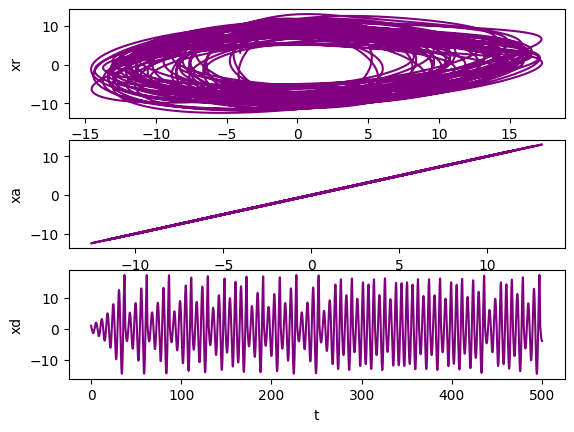

In [1]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

a = 0.15;
p = 0.2;
c = 10.0;
wr = 0.95;
wd = 0.99;
e = 0.13;

def rossler(H, t=0):
    return np.array([(-wd*H[1])-H[2], #xd 0
                    (wd*H[0])+(a*H[1]), #yd 1
                    p+(H[2]*(H[0]-c)), #zd 2 
                    ((-wr*H[4])-H[5])+e*(H[0]-H[3]), #xr 3
                    (wr*H[3])+(a*H[4]), #yr 4 
                    p+(H[5]*(H[3]-c)), #zr 5
                    (((-wr*H[7])-H[8])+e*(H[0]-H[6])), #xa 6
                    ((wr*H[6])+(a*H[7])), #ya 7 
                    p+(H[8]*(H[6]-c))]) #za 8 
                    

T = 1000000; T0 = 400000;
t = np.linspace(0, 500, T)
#t = np.linspace(0, T/2, T)
#t = np.arange(0.1, 10000, 0.01)
#T0 = 920000


#H0 = [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.1, 0.1, 0.1]
H0 = [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1.05, 1.05, 1.05 ]
#H0 = [0.001, 0.001, 0.001, 0.001, 0.001, 0.001,]
H, infodict = integrate.odeint(rossler, H0, t, full_output=True)

fig, axs = plt.subplots(3)
axs[0].plot(H[T0:,0],H[T0:,3],c='purple') #xd xr
axs[1].plot(H[T0:,3],H[T0:,6],c='purple') #xr,xa
axs[2].plot(t,H[:,0],c='purple')

#plt.plot(H[:,3],H[:,6],c='purple') #xr,xa
#plt.plot(H[1000:,0],H[1000:,3],c='purple')
plt.setp(axs[0], xlabel='xd')
plt.setp(axs[0], ylabel='xr')
plt.setp(axs[1], xlabel='xr')
plt.setp(axs[1], ylabel='xa')
plt.setp(axs[2], xlabel='t')
plt.setp(axs[2], ylabel='xd')
plt.show()
#v = np.array(np.meshgrid(H[T0:,0], H[T0:,3])).T.reshape(-1, 2)
#v = np.array(np.meshgrid(H[T0:,3], t[T0:])).T.reshape(-1, 2)
#print(t[T0:])
#np.savetxt('xt.csv', v, delimiter=",")

#print(len(H[T0:,0]))







In [2]:
q = np.vstack((H[T0:,0],t[T0:])).T
df = pd.DataFrame(q, columns = ['x','t'])

df1 = pd.DataFrame(H[T0:,0])
print(df)
print(df1)

               x         t
0      -8.845905  200.0002
1      -8.845738  200.0007
2      -8.845568  200.0012
3      -8.845396  200.0017
4      -8.845222  200.0022
...          ...       ...
599995 -4.033152  499.9980
599996 -4.033034  499.9985
599997 -4.032916  499.9990
599998 -4.032796  499.9995
599999 -4.032675  500.0000

[600000 rows x 2 columns]
               0
0      -8.845905
1      -8.845738
2      -8.845568
3      -8.845396
4      -8.845222
...          ...
599995 -4.033152
599996 -4.033034
599997 -4.032916
599998 -4.032796
599999 -4.032675

[600000 rows x 1 columns]


<Axes: xlabel='t', ylabel='x'>

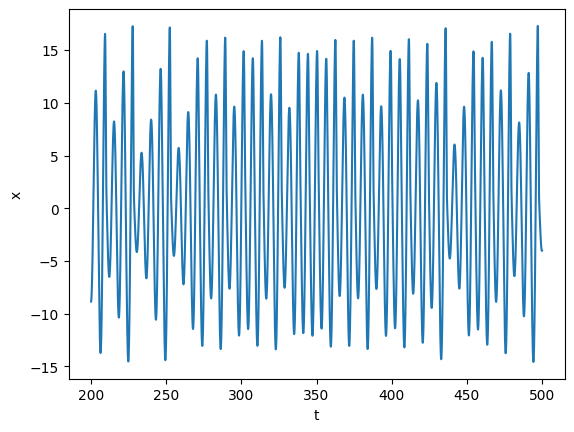

In [3]:
sns.lineplot(x='t', y='x', data=df)

<Axes: >

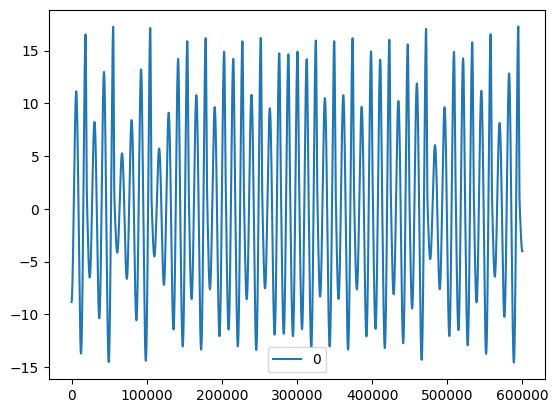

In [4]:
df1.plot()

In [5]:
t1 = t[T0:]
print(t1)

[200.0002 200.0007 200.0012 ... 499.999  499.9995 500.    ]


In [6]:
def df_to_X_y(df,t, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row=[a for a in df_as_np[i:i+5]]
    X.append(row)
    label=df_as_np[i+5]
    y.append(label)
  return np.array(X),np.array(y)

In [7]:
WINDOW_SIZE = 5
X,y = df_to_X_y(df1,t1,WINDOW_SIZE)
X.shape, y.shape

((599995, 5, 1), (599995, 1))

In [8]:
y=y.flatten()

In [9]:
X_train, y_train = X[:500000], y[:500000]
X_val, y_val = X[500000:550000], y[500000:550000]
X_test, y_test = X[550000:], y[550000:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((500000, 5, 1), (500000,), (50000, 5, 1), (50000,), (49995, 5, 1), (49995,))

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [11]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [12]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, callbacks=[cp1])

Epoch 1/5
15624/15625 [============================>.] - ETA: 0s - loss: 1.7264 - root_mean_squared_error: 1.3139

15625/15625 [==============================] - 96s 6ms/step - loss: 1.7262 - root_mean_squared_error: 1.3139 - val_loss: 1.7693e-04 - val_root_mean_squared_error: 0.0133
Epoch 2/5
15621/15625 [============================>.] - ETA: 0s - loss: 1.4991e-04 - root_mean_squared_error: 0.0122

15625/15625 [==============================] - 97s 6ms/step - loss: 1.4991e-04 - root_mean_squared_error: 0.0122 - val_loss: 1.2426e-04 - val_root_mean_squared_error: 0.0111
Epoch 3/5
15618/15625 [============================>.] - ETA: 0s - loss: 1.2296e-04 - root_mean_squared_error: 0.0111

15625/15625 [==============================] - 102s 7ms/step - loss: 1.2295e-04 - root_mean_squared_error: 0.0111 - val_loss: 8.6707e-05 - val_root_mean_squared_error: 0.0093
Epoch 4/5
15625/15625 [==============================] - 89s 6ms/step - loss: 1.0276e-04 - root_mean_squared_error: 0.0101 - val_loss: 1.3579e-04 - val_root_mean_squared_error: 0.0117
Epoch 5/5
15620/15625 [============================>.] - ETA: 0s - loss: 8.3491e-05 - root_mean_squared_error: 0.0091

15625/15625 [==============================] - 94s 6ms/step - loss: 8.3483e-05 - root_mean_squared_error: 0.0091 - val_loss: 7.2805e-05 - val_root_mean_squared_error: 0.0085


In [13]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [14]:
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
train_results

15625/15625 [==============================] - 45s 3ms/step


,Train Predictions,Actuals
0,-8.851311,-8.845046
1,-8.851137,-8.844867
2,-8.850962,-8.844687
3,-8.850783,-8.844504
4,-8.850602,-8.844319
...,...,...
499995,-3.260841,-3.265376
499996,-3.266121,-3.270646
499997,-3.271402,-3.275915
499998,-3.276682,-3.281184


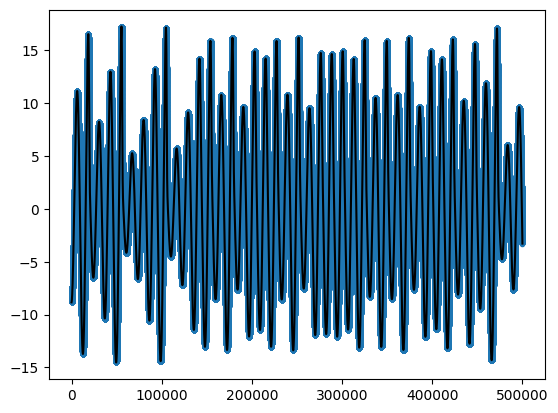

In [15]:
plt.plot(train_results['Train Predictions'],'.')
plt.plot(train_results['Actuals'],c='black')

In [16]:
val_predictions = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val})
val_results

1563/1563 [==============================] - 5s 3ms/step


,Val Predictions,Actuals
0,-3.287241,-3.291720
1,-3.292520,-3.296987
2,-3.297799,-3.302255
3,-3.303077,-3.307521
4,-3.308355,-3.312788
...,...,...
49995,-9.480792,-9.484944
49996,-9.485505,-9.489654
49997,-9.490217,-9.494361
49998,-9.494926,-9.499066


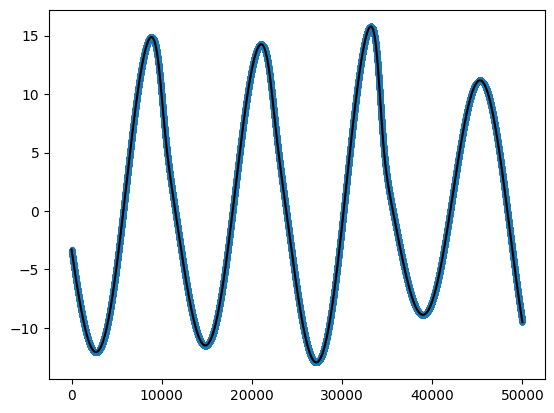

In [17]:
plt.plot(val_results['Val Predictions'],'.')
plt.plot(val_results['Actuals'],c='black')

In [18]:
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'test Predictions':test_predictions, 'Actuals':y_test})
test_results


1563/1563 [==============================] - 4s 3ms/step


,test Predictions,Actuals
0,-9.504341,-9.508471
1,-9.509046,-9.513170
2,-9.513747,-9.517867
3,-9.518447,-9.522563
4,-9.523147,-9.527256
...,...,...
49990,-4.036674,-4.033152
49991,-4.036558,-4.033034
49992,-4.036439,-4.032916
49993,-4.036320,-4.032796


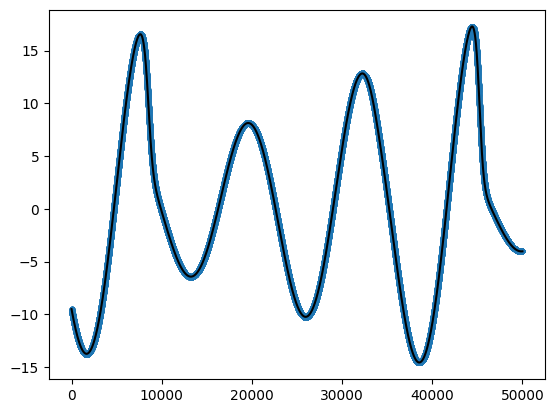

In [19]:
plt.plot(test_results['test Predictions'],'.')
plt.plot(test_results['Actuals'],c='black')

In [20]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions1(model, X, y):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'])
  plt.plot(df['Actuals'])
  return df, mse(y, predictions)

1563/1563 [==============================] - 5s 3ms/step


(       Predictions   Actuals
 0        -9.504341 -9.508471
 1        -9.509046 -9.513170
 2        -9.513747 -9.517867
 3        -9.518447 -9.522563
 4        -9.523147 -9.527256
 ...            ...       ...
 49990    -4.036674 -4.033152
 49991    -4.036558 -4.033034
 49992    -4.036439 -4.032916
 49993    -4.036320 -4.032796
 49994    -4.036200 -4.032675
 
 [49995 rows x 2 columns],
 8.583631403794322e-05)

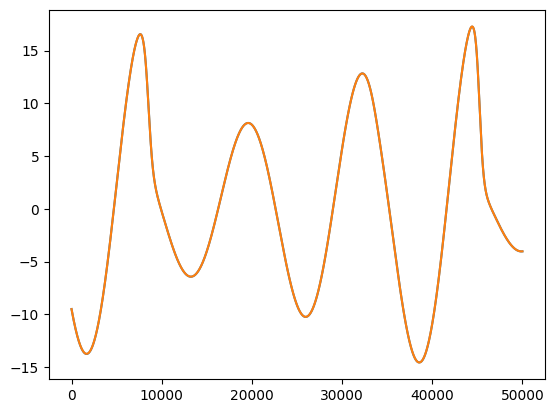

In [21]:
plot_predictions1(model1, X_test, y_test)

In [22]:
pred = model1.predict(X_test)
pred = pd.DataFrame(pred)

1563/1563 [==============================] - 5s 3ms/step


In [23]:
pred1 = model1.predict(X_train)
pred1 = pd.DataFrame(pred1)
pred1.to_csv(f"xd_003.csv",index=False,header=None)

15625/15625 [==============================] - 57s 4ms/step


In [24]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 21.4 MB/s eta 0:00:00


In [25]:
import tensorflow_addons as tfa
metric = tfa.metrics.r_square.RSquare()
metric.update_state(y_train, train_predictions)
result = metric.result()
result.numpy()

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


0.9999989

In [26]:
!pip install tf-nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.2/524.2 MB 813.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 441.0/441.0 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 72.0 MB/s eta 0:00:00


In [27]:
import tf-nightly as tfn

#y_true = np.array([[1], [4], [3]], dtype=np.float32)
#y_pred = np.array([[2], [4], [4]], dtype=np.float32)
metric = tfn.keras.metrics.R2Score()
metric.update_state(y_train, train_predictions)
result = metric.result()
result.numpy()

AttributeError: ignored

In [28]:
from sklearn.metrics import r2_score

r2_score(y_train, train_predictions)

0.9999989562816021